[Go to this directory index](./)

Contents
  - [Early optimization trials](#Early-optimization-trials)
    - [Background](#Background)
      - [Handling constraints](#Handling-constraints)
      - [Handling heat transfer](#Handling-heat-transfer)
    - [Code samples](#Code-samples)
      - [Input vectors](#Input-vectors)
      - [Trials with scipy.optimize, constrained optimization](#Trials-with-scipy.optimize,-constrained-optimization)
      - [Primitive barrier: first attempt](#Primitive-barrier:-first-attempt)
      - [Primitive barrier: second attempt](#Primitive-barrier:-second-attempt)
      - [Constraint mode 'genopt1'](#Constraint-mode-'genopt1')
      - [Constraint mode ](#Constraint-mode-genopt2)
    - [Trials with scipy.optimize](#Trials-with-scipy.optimize)
      - [Setup for scipy.optimize trials](#Setup-for-scipy.optimize-trials)
      - [Results with scipy.optimize](#Results-with-scipy.optimize)
      - [Discussion](#Discussion)
    - [GenOpt trials](#GenOpt-trials)
      - [Setup for opt1](#Setup-for-opt1)
      - [Setup for trial opt2](#Setup-for-trial-opt2)
      - [Setup for trial opt3](#Setup-for-trial-opt3)
      - [Setup for trial opt4](#Setup-for-trial-opt4)
      - [Setup for trial opt5](#Setup-for-trial-opt5)
      - [Results with GenOpt](#Results-with-GenOpt)
      - [Discussion of GenOpt trials](#Discussion-of-GenOpt-trials)

# Early optimization trials

## Background

Recall that the goal was to optimize the cooling capacity of a heat-driven cooling system, by adjusting the internal design parameters of the chiller subsystem and heat exchangers. In optimization language, the objective to minimize is the additive inverse of the cooling capacity. Three external streams are treated as inputs defined at their inlet to the heat exchangers (one as heat supply, one for heat rejection, and another to deliver cooling to the load). Furthermore, the goal for the maximum "cost" (monetary, material, etc) associated with the design is treated as a constraint. The challenges with delivering satisfactory optimization trials appear to come from properly constraining the optimization problem, and possibly from insufficient smoothness due to numerical methods for evaluating heat transfer.

The internal design parameters are the sizes of the heat exchangers, pumped mass flow rates, and valve coefficients if present. However, with heat exchanger sizes as the inputs, solving requires iteration to determine fluid states at key points (similar to a transient solver converging to steady state). Despite potential disadvantages, we wanted to go with the simplest possible model, so instead I treated as inputs the fluid states at key points (a handful of temperatures and absorbate concentrations), which decouples solving the internal cycle from the external streams. Then the model is solved in one pass. The downside is that it becomes possible to give the model an infeasible set of inputs, for which the cycle doesn't solve but yields an error. Constraints that make the cooling cycle feasible are called **hard constraints** (they must be always observed). Constraints that pertain to feasible heat transfer and cost goal are considered **soft constraints**, because they can be violated during the process of optimization as long as they eventually are resolved. Going forward, we could change out some hard constraints by rearranging the model to group blocks of the cycle that could be solved independently, resulting in mismatch in mass/species/energy instead of a solver error, and treat the mismatch as a soft constraint (more like the equation-solver approach).

Originally, I developed my models intending to use the [optimization library from Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html), called directly in Python from module `scipy.optimize`. After early trials failed to yield satisfying results, I attempted to use [GenOpt tool from LBL](https://simulationresearch.lbl.gov/GO/) (a standalone Generic Optimization program coded in Java, with [source on GitHub](https://github.com/lbl-srg/GenOpt), not to be confused with any other GenOpt). Below I will show the results of the early (ie. not yet satisfying) trials for the single-effect ammonia-water absorption cycle system.

To clarify language, the code uses classes to encapsulate the following objects seen in source files `ammonia1.py` and `system_aqua1.py`:

- `Problem(System sys, goal_UA)`. The optimization problem currently being solved including methods to evaluate the objective, constraints, solver options. This object calls on a System object to handle model calculations.
- `System(Boundary bdry, Chiller ch)`. Couples together calculations involving the cooling subsystem and the external streams.
- `Chiller(chiller spec)`. The model for the chiller subsystem defined by a specification; for the set of input variables, a shortcut is provided as `makeChiller(xC)` for the input vector `xC = mdot, T1, T2, ...`.
- `Boundary(Stream heat_supply, Stream heat_rejection, Stream cooling)`. The set of external streams. For convenient initialization and hashing, a shortcut is provided as `makeBoundary(xB)` where the input vector `xB = (T_inlet_1, m_1, T_inlet_2, m_2, ...)`. (Although the shortcut generates three sensible streams with the specific heat of liquid water, this does not mean that you have designed a water-cooled system; you could change $c_p$ and expect the same results, as discussed in the prospectus. A future revision should clarify by asking to input $\dot m c_p$ instead of $\dot m$, but meanwhile I already have the trials indexed by this definition of `xB`.)
- `Stream`. Must implement methods `q(T)` and `T(q)` to describe the (q,T) curve for a particular process. For example, a straight-through flow process would have $q = \dot m \Delta h$. A desorber or absorber may have internally counterflowing gas and liquid streams, so the equation takes on a different form (confer prior writings and textbooks).

We set up the problem in order to look at parameter studies where we loop over a range of values for some variable fixed during optimization, such as `goal_UA` or `xB`, so these are described by vectors in order to hash and store the results for easy lookup.

### Handling constraints

In the scipy library there are some bounded and constrainted optimization solvers, allowing for constraints to be passed in as a vector separately from the objective. That is easy, so in my first attempt, the system includes a list of all constraints in the system object.

However, other than box constraints (variable bounds), GenOpt directs the user to build a custom Optimizer or incorporate the constraints into a modified objective function. The GenOpt manual includes a discussion of numerical methods, such as barrier and penalty functions, and these methods are adopted when optimizing with GenOpt.

Note that scipy.optimize takes the convention that inequality constraints are of the form

$$ C_j(x) \ge 0 $$

whereas GenOpt takes the convention that inequality constraints are of the form

$$ g_i(x) \le 0, $$

so the code has to wrap the outputs depending on the choice of optimizer interface.

### Handling heat transfer

In the `HRHX_integral_model` (since [1e79c81](https://github.com/nfette/openACHP/commit/1e79c81e4ea44572713f2f755ef70c20d6b8732c#diff-657bfcb686553b7168f7119358de9898)), I use the integral version of the counterflow heat exchange equation relating UA and Q (see my prospectus, eqn. #10), which depends on two curves, (Q, T) for the cold and hot streams. With the current choice of inputs, the Q is fixed by the cooling cycle, we just need to perform the integral to get UA. The [integration library from Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html) provides numerical integration routines, so I used that. Naturally, this results in long computation times to evaluate UA given Q. (Furthermore, if effectiveness or pinch point are desired, that requires an additional call to a minimize routine. Sometimes I have tried to use as constraints the effectiveness or $\Delta T$ at pinch.) This is because for each stream, evaluating each point on the (q,T) curve involves fluid property lookups, including possibly iterative solves with enthalpy as input, and a little arithmetic. Thus in commit [1726931](https://github.com/nfette/openACHP/commit/1726931267697a4abbed7557a59d36680f97fbf8#diff-657bfcb686553b7168f7119358de9898), I introduced a trick intended to reduce computation time: to limit the number of property lookups, I make a spline of the (q,T) curve prior to integration (with a new stream object). Per point, the spline interpolate is faster than the direct property lookup, and the inverse curve is obtained for free. I have chosen to build the spline from a fixed number of points, which introduces potential error from discretization. TODO: profile the code to produce a table comparing the time to evaluate a System model with and without the interpolate.

At the moment, to evaluate Q given UA, I just minimize the error in UA, because I already have a function UA(Q). This is not ideal, because Q(UA) is the more physical problem (always feasible to solve). It would make sense to use a finite element method. Perhaps that would be a good future addition.

## Code samples

### Input vectors

Here is how we map the Boundary and Chiller specifications. From `system_aqua1.py`:

```python
def makeBoundary(x):
    """Given a iterable x that represents 5 stream inlets as T,m pairs,
    returns the Boundary object representing that.
    
    t0,m0,t1,m1,t2,m2,t3,m3,t4,m4 = x
    
    Note that boundary streams are
    
    0
        heat
    1
        absorberReject
    2
        condenserReject
    3
        cold
    4
        rectifierReject
    """
    t0, m0, t1, m1, t2, m2, t3, m3, t4, m4 = x
    # Units: K, kg/s, kW/kg-K
    cp = 4.179
    return Boundary(
        heat=streamExample1(t0, m0, cp),
        absorberReject=streamExample1(t1, m1, cp),
        condReject=streamExample1(t2, m2, cp),
        cold=streamExample1(t3, m3, cp),
        rectifierReject=streamExample1(t4, m4, cp))


def makeChiller(x):
    """Given a iterable x that represents a chiller state,
    return a chiller object.
    
    Args
    ====
    
    x[0]
        m_rich (kg/s)
    x[1]
        T_evap (K)
    x[2]
        T_cond (K)
    x[3]
        T_rect (K)
    x[4]
        T_abs_outlet (K)
    x[5]    
        T_gen_outlet (K)
    """
    chiller = ammonia1.AmmoniaChiller()
    m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet = x
    chiller.update(m_rich=m_rich,
                   T_evap=T_evap,
                   T_cond=T_cond,
                   T_rect=T_rect,
                   T_abs_outlet=T_abs_outlet,
                   T_gen_outlet=T_gen_outlet)
    return chiller
```

### Trials with scipy.optimize, constrained optimization
Here is how we computed constraints for constrained optimization solvers in scipy.optimize. The constraint functions (desired to be non-negative) passed to the optimizer are:

\begin{align}
C_0 &= m_{rich} \\
C_1 &= T_{cond} - T_{evap} \\
C_2 &= T_{rect} - T_{cond} \\
C_3 &= T_{generator\ outlet} - T_{rect} \\
C_4 &= T_{generator\ outlet} - T_{absorber\ outlet} \\
C_5 &= \Delta T_{generator} \\
C_6 &= \Delta T_{rectifier} \\
C_7 &= \Delta T_{absorber} \\
C_8 &= \Delta T_{condenser} \\
C_{9} &= \Delta T_{evaporator} \\
C_{10} &= UA_{goal} - UA_{actual}
\end{align}

The code that accomplishes this includes a lookup function so that the System() is only called once per unique combination of inputs, but otherwise is equivalent to:

```python
class Problem(object):
    
    def __init__(self, bdry, UAgoal, constraintMode=None, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.constraintMode = constraintMode
        self.mu = 0.1
        self.input = []
        self.output = dict()
        self.Ncons = 11
        if constraintMode == None:
            # Automatic constraints mode: minimizer imposes all constraints.
            # This object is sent to minimizer with handles back to self.
            # See definition of constraint() below.
            # Confusingly, some code comments called this soft constraints mode.
            self.constraints = [{'type': 'ineq',
                                 'fun': self.constraint,
                                 'args': (i,)} for i in range(self.Ncons)]
        else:
            # Manual constraints modes: objective function modified.
            # See definition of objective() below.
            # Confusingly, some code comments called this hard constraints mode.
            self.constraints = []

    def objective(self, x, stepNumber=1):
        """Return the value of the objective function to minimize. This is
        :math:`-Q_{evap}` modified depending on constraintMode.
        """
        try:
            sys = System(self.bdry, makeChiller(x))
            Q = sys.chiller.Q_evap
        except Exception as e:
            Q = 0
            
        if self.constraintMode != None:
            raise NotImplementedError
            
        return -Q

    def constraint(self, x, *args):
        i, = args
        cons = [x[0],
                x[2] - x[1],
                x[3] - x[2],
                x[5] - x[3],
                x[5] - x[4]]
        try:
            sys = System(self.bdry, makeChiller(x))
            # This loops over external-facing heat exchangers
            for name, deltaT, epsilon, UA, Qhx in sys.data:
                cons.append(deltaT)
            cons.append(self.UAgoal - sys.totalUA)
        except Exception as e:
            while len(cons) < self.Ncons:
                cons.append(-1)
        return cons[i]
            
def makeOrGetProblemForBoundary(
        xB, U, xC, method=None, options=None, folder='data', create=False):
    ...
    # Create the data
    opt, err = None, None
    bdry = makeBoundary(xB)
    p = Problem(bdry, U, constraintMode=None)
    try:
        opt = minimize(p.objective,
                       xC,
                       constraints=p.constraints,
                       method=method,
                       options=options)
    ...
    return xB, bdry, p, opt, err

```

### Primitive barrier: first attempt

Here is how we compute the modified objective function. In the GenOpt trial 1 (`opt1` folder), I used my primitive barrier function, thus, in `src/system_aqua1.py`. Note that the loop `for row in sys.data` iterates over the external facing heat exchangers.

```python
def main2():
    """Script to run with GenOpt, using a stupid barrier function"""

    import sys  # command args
    import traceback  # display errors into log
    import json  # read input file with standard, structured format
    from decimal import Decimal  # convert 'inf' to 'Infinity' etc

    infile, outfile, logfile = sys.argv[1:4]

    with open(logfile, 'w') as log:
        print('infile="{}"'.format(infile), file=log)
        print('outfile="{}"'.format(outfile), file=log)
        print('logfile="{}"'.format(logfile), file=log)

        try:
            with open(infile) as fin:
                data = json.load(fin)
            stepNumber = data['stepNumber']
            UAgoal = data['UAgoal']
            xB = data['xB']
            xC = data['xC']
            print('UAgoal={}'.format(UAgoal), file=log)
            print('xB={}'.format(xB), file=log)
            print('xC={}'.format(xC), file=log)
            bdry = makeBoundary(xB)
            chiller = makeChiller(xC)
            sys = System(bdry, chiller)
            print(sys, file=log)

            with open(outfile, 'w') as fout:
                print("Q_evap=", chiller.Q_evap, file=fout)
                sum_g_barrier = 0
                for row in sys.data:
                    name, deltaT, epsilon, UA, Qhx = row
                    print("UA_{}={}".format(name, Decimal(UA)), file=fout)
                    print("deltaT_{}={}".format(name, Decimal(deltaT)), file=fout)
                    sum_g_barrier += deltaT
                print("sum_g_barrier={}".format(Decimal(sum_g_barrier)), file=fout)
                mu = 3 / stepNumber
                print("mu={}".format(mu), file=fout)

        except:
            traceback.print_exc(file=log)
```

I pass the value to GenOpt via the configuration file, `opt1\pythonSimulation.cfg`:

```java
ObjectiveFunctionLocation{
    Name1      = objective;
    Function1  = "add(-%Q_evap%, multiply(%mu%,-%sum_g_barrier%))";
    Name2      = Q_evap;
    Delimiter2 = "Q_evap=";
    Name3      = UA_gen; // gen rect abs cond evap
    Delimiter3 = "UA_gen=";
    Name4      = UA_rect;
    Delimiter4 = "UA_rect=";
    Name5      = UA_abs;
    Delimiter5 = "UA_abs=";
    Name6      = UA_cond;
    Delimiter6 = "UA_cond=";
    Name7      = UA_evap;
    Delimiter7 = "UA_evap=";
    Name8      = deltaT_gen; // gen rect abs cond evap
    Delimiter8 = "deltaT_gen=";
    Name9      = deltaT_rect;
    Delimiter9 = "deltaT_rect=";
    Name10      = deltaT_abs;
    Delimiter10 = "deltaT_abs=";
    Name11      = deltaT_cond;
    Delimiter11 = "deltaT_cond=";
    Name12      = deltaT_evap;
    Delimiter12 = "deltaT_evap=";
    Name13      = con1;
    Function13  = "%m_rich%";
    Name14      = con2;
    Function14  = "add(%T_cond%, -%T_evap%)";
    Name15      = con3;
    Function15  = "subtract(%T_rect%, %T_cond%)";
    Name16      = con4;
    Function16  = "subtract(%T_gen_outlet%, %T_rect%)";
    Name17      = con5;
    Function17  = "subtract(%T_gen_outlet%, %T_abs_outlet%)";
    Name18      = mu;
    Delimiter18  = "mu=";
    Name19      = sum_g_barrier;
    Delimiter19 = "sum_g_barrier=";
}
```

### Primitive barrier: second attempt

After the linear barrier function above, I tried applying the expit function (logistic curve) to smooth the barriers.

$$ Objective = -Q \prod_{j} \mathrm{expit}(C_j / \mu) $$

This was implemented in `Problem.objective()` thus:

```python
def objective(self, x, stepNumber=1):
    Q, cons = self.lookup(x, printing=True)
    if self.constraintMode == 'expit':
        mu = self.mu
        for c in cons:
            Q *= expit(c / mu)
        return -Q
    else:
        return -Q
```

This was probably a bad idea; better options are discussed below.

### Constraint mode 'genopt1'

I added more sophisticated, separate barrier (B) and penalty (P) functions and passed these to the optimizer.
In GenOpt trial folders `opt2` through `opt5`, I used this technique. I may also have tried this with scipy.optimize (which trials?). The objective function is, (as documented in source), with step number as $k$,

$$ Objective = -Q_{cooling}(x) + \mu_1 B(x) + \mu_2 P(x) $$

$$ \mu_1 = k^{-2}$$
$$ B(x) = \sum_{j=0}^{9} g_j$$

$$\mu_2 = k^{2}$$
$$ P(x) = \sum_{j=10}^{10} g_j$$



This was implemented thus: for the scipy.optimize routines, in Python,

```python
def objective(self, x, stepNumber=1):
    Q, cons = self.lookup(x, printing=True)
    if self.constraintMode == 'genopt1':
        # Each cons[i] > 0 by scipy convention,
        # So need to change the sign of the second term.

        # GenOpt eqn. 8.6
        barrier = 0
        for c in cons[:10]:
            g = -c
            barrier += g
        # Eqn. 8.7
        mu1 = stepNumber ** (-2)

        # GenOpt eqn. 8.8
        penalty = 0
        for c in cons[10:]:
            g = -c
            penalty += max(0, g) ** 2
        # Eqn 8.9
        mu2 = stepNumber ** (2)

        f_tilde = -Q + mu1 * barrier + mu2 * penalty
        return f_tilde
    else:
        return -Q
```

And for the GenOpt optimizer, in Python:

```python
def systemConstraints(sys, UAgoal):
    T_evap = sys.chiller.refrig_evap_outlet.T
    T_cond = sys.chiller.refrig_cond_outlet.T
    T_rect = sys.chiller.refrig_rect_outlet.T
    T_gen_outlet = sys.chiller.weak_gen_outlet.T
    T_abs_outlet = sys.chiller.rich_abs_outlet.T
    hardConstraints = [T_cond - T_evap,
                       T_rect - T_cond,
                       T_gen_outlet - T_rect,
                       T_gen_outlet - T_abs_outlet]
    # name, deltaT, epsilon, UA, Q
    deltaTT = [hx[1] for hx in sys.data]
    for deltaT in deltaTT:
        hardConstraints.append(deltaT)

    softConstraints = [UAgoal - sys.totalUA]

    # GenOpt eqn. 8.6
    barrier = 0
    for c in hardConstraints:
        g = -c
        barrier += g
    # Eqn. 8.7
    # mu1 = stepNumber ** (-2)

    # GenOpt eqn. 8.8
    penalty = 0
    for c in softConstraints:
        g = -c
        penalty += max(0, g) ** 2
    # Eqn 8.9
    # mu2 = stepNumber ** (2)

    return barrier, penalty
    
    
def main3(infile, outfile, logfile):
    """Script to run with GenOpt, using more intelligent constraints."""

    import traceback  # display errors into log
    import json  # read input file with standard, structured format
    from decimal import Decimal  # convert 'inf' to 'Infinity' etc

    with open(logfile, 'w') as log:
        print('infile="{}"'.format(infile), file=log)
        print('outfile="{}"'.format(outfile), file=log)
        print('logfile="{}"'.format(logfile), file=log)

        try:
            with open(infile) as fin:
                data = json.load(fin)
            stepNumber = data['stepNumber']
            UAgoal = data['UAgoal']
            xB = data['xB']
            xC = data['xC']
            print('UAgoal={}'.format(UAgoal), file=log)
            print('xB={}'.format(xB), file=log)
            print('xC={}'.format(xC), file=log)
            bdry = makeBoundary(xB)
            chiller = makeChiller(xC)
            sys = System(bdry, chiller)
            print(sys, file=log)
            barrier, penalty = systemConstraints(sys, UAgoal) # Look here

            with open(outfile, 'w') as fout:
                if np.isinf(barrier) or np.isinf(penalty):
                    print("Q_evap=", -1, file=fout)
                    print("barrier=", 0, file=fout)
                    print("penalty=", 0, file=fout)
                else:
                    print("Q_evap=", chiller.Q_evap, file=fout)
                    print("barrier=", barrier, file=fout)
                    print("penalty=", penalty, file=fout)

        except:
            traceback.print_exc(file=log)

```

Then in the GenOpt configuration,

```java
ObjectiveFunctionLocation{
    Name1      = objective;
    Function1  = "add(multiply(-1,%Q_evap%), %barrier_and_penalty%)";
    Name2      = Q_evap;
    Delimiter2 = "Q_evap=";
    Name3      = barrier_and_penalty;
    Function3  = "add(multiply(%mu1%,%barrier%),multiply(%mu2%,%penalty%))";
    Name4      = barrier;
    Delimiter4 = "barrier=";
    Name5      = penalty;
    Delimiter5 = "penalty=";
    Name6      = mu1;
    Function6  = "pow(%stepNumber%,-2)";
    Name7      = mu2;
    Function7  = "pow(%stepNumber%,2)";
}
```


### Constraint mode `genopt2`

Comparing what I just wrote to the GenOpt manual, it appears that I made a mistake. GenOpt suggests a barrier function be of this form (eqn 8.6):

$$ B(x) = \frac{1}{\sum_{i} g_i(x) } $$

Thus, TODO: implement a constraint mode `genopt2` to invert the sum.

## Trials with scipy.optimize

### Setup for scipy.optimize trials

The problem was defined with a UA goal of 100, heat supply temperature of 400 K, and cooling load temperature of 285 K, thus:

```python
def playback(method,folder,U=100,rejectTT=np.arange(20,61,5)):
    ...

    for i,rejectT in enumerate(rejectTT):
        rT = C2K(rejectT)
        xB = np.array([400,1, rT,3, rT,5, 285,4, rT,0.15], dtype=np.double)
        # m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet = x        
        xC0 = np.array([0.05, 278.45, rT+7, rT+8, rT+5, 395.15])
        ...
```

Here are 12 trials generated by the `aqua_case_studies2` module, which calls `system_aqua1` to run `scipy.optimize.minimize` with the selected optimizer method, over a range of temperatures for the heat rejection stream at the inlet to the system. For each trial, I will plot convergence of the optimizer for each temperature in the range, then plot once the optimum cooling capacity discovered during the search. Sometimes, the optimizer ends outside the feasible region, so I backtrack to the best search attempt.

In [1]:
%load_ext autoreload
%autoreload 2
import system_aqua1
import aqua_case_studies2

In [2]:
aqua_case_studies2.trials

{'data': {'method': 'COBYLA', 'options': {'rhobeg': 0.01}},
 'data10': {'method': 'SLSQP'},
 'data11': {'method': 'dogleg'},
 'data12': {'method': 'trust-ncg'},
 'data2': {'method': None},
 'data3': {'method': 'Nelder-Mead'},
 'data4': {'method': 'Powell'},
 'data5': {'method': 'CG'},
 'data6': {'method': 'BFGS'},
 'data7': {'method': 'Newton-CG'},
 'data8': {'method': 'L-BFGS-B'},
 'data9': {'method': 'TNC'}}

In [3]:
help(aqua_case_studies2.playback)

Help on function playback in module aqua_case_studies2:

playback(method, folder, U=100, rejectTT=array([20, 25, 30, 35, 40, 45, 50, 55, 60]), output_sys_data=False)



### Results with scipy.optimize

In [4]:
def nbplayback(folder):
    try:
        with open('../' + folder + '/readme.txt','r') as f:
            print(f.read())
    except:
        print('This trial contains no readme file.')
    args = aqua_case_studies2.trials[folder]
    aqua_case_studies2.trials[folder]['results'] \
        = aqua_case_studies2.playback(args['method'],folder,output_sys_data=True)

Note: these files were created by system_aqua1.py
* Prior to adding the hardConstraints feature
* Using COBYLA with rhobeg = 0.01

Loaded the case from  ../data/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl
At 1157e8eaf40a07ed8148134656455f56 caught "DLL returned b'Saturation properties cannot be determined for the given input variables'"


C:\Users\user1\Documents\GitHub\openACHP\src\aqua_case_studies2.py:91: RuntimeWarning: invalid value encountered in greater_equal
  mask = (po['cons'] >= 0).all(axis=1)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
At 1157e8eaf40a07ed8148134656455f56 caught "DLL returned b'Saturation properties cannot be determined for the given input variables'"
Loaded the case from  ../data/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
At 1157e8eaf40a07ed8148134656455f56 caught "DLL returned b'Saturation properties cannot be determined for the given input variables'"
Loaded the case from  ../data/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
At 1157e8eaf40a07ed8148134656455f56 caught "DLL returned b'Saturation properties cannot be determined for the given input variables'"
Loaded the case from  ../data/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
At 2690b39

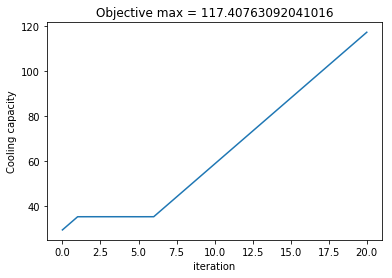

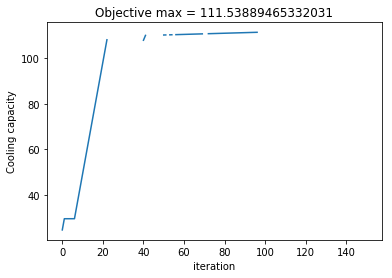

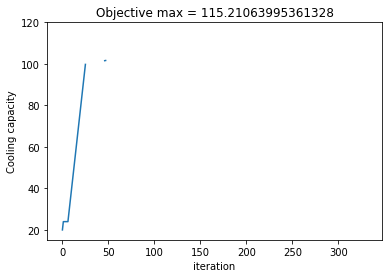

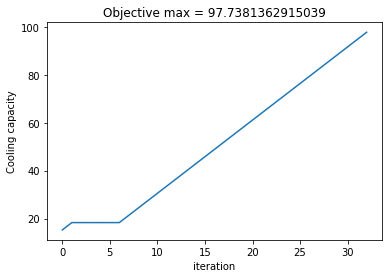

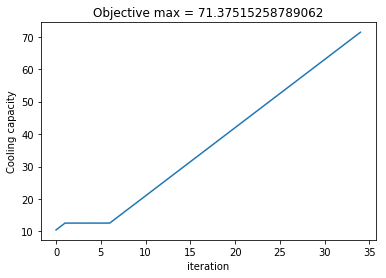

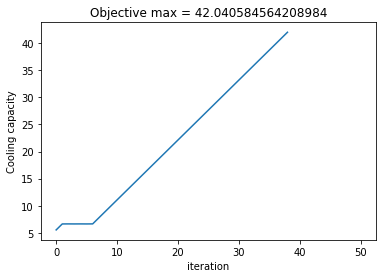

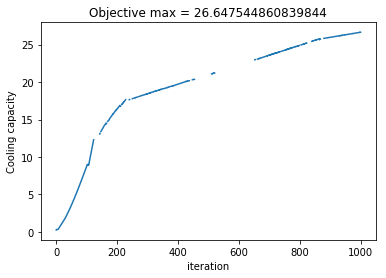

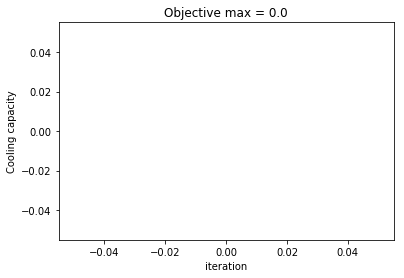

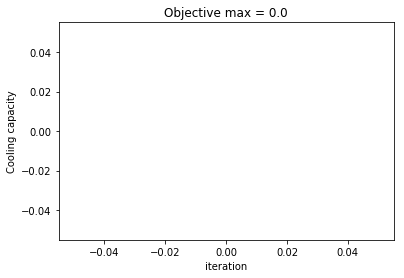

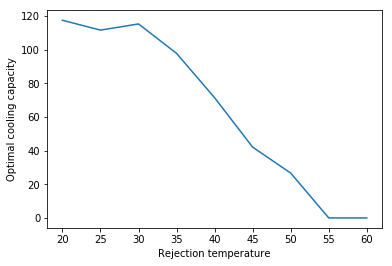

In [9]:
nbplayback('data')

Note: these files were created by system_aqua1.py
* With hardConstraints = True
* Using default minimize options (BFGS)
* Each boundary condition took about 20 minutes
Loaded the case from  ../data2/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data2/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data2/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data2/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data2/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data2/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data2/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data2/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data2/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


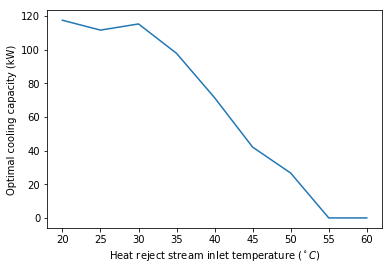

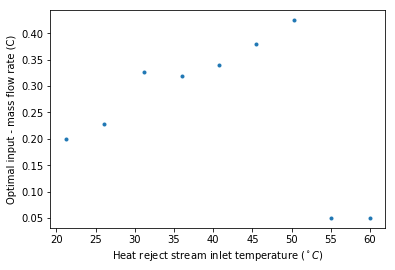

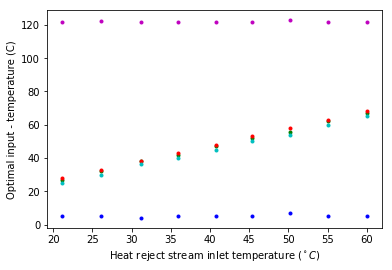

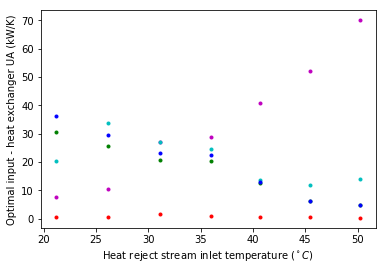

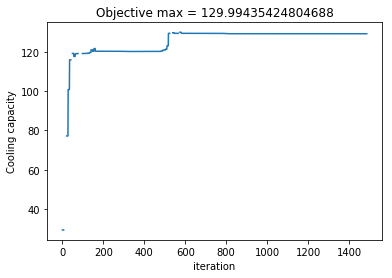

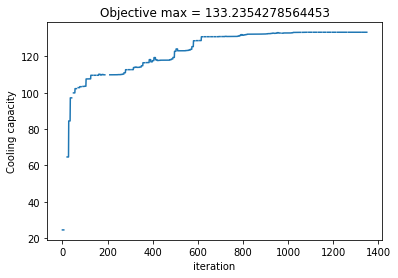

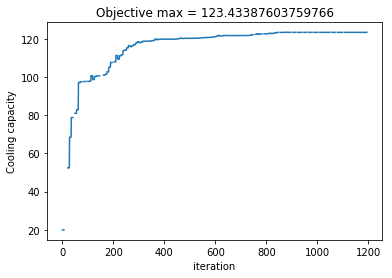

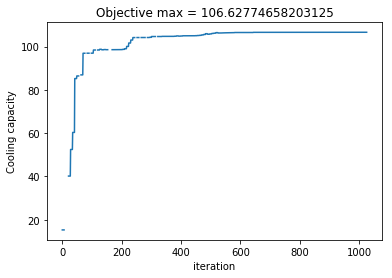

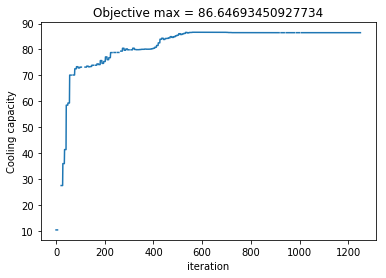

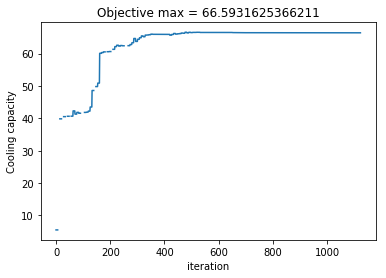

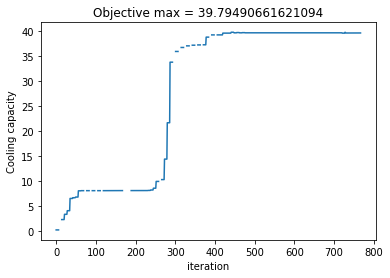

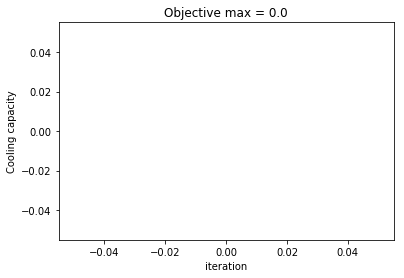

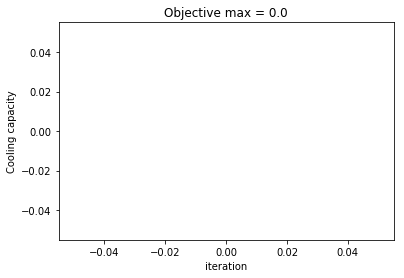

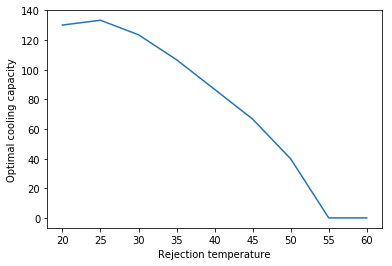

In [28]:
nbplayback('data2')

This trial contains no readme file.
Loaded the case from  ../data3/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data3/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl


C:\Users\user1\Documents\GitHub\openACHP\src\aqua_case_studies2.py:91: RuntimeWarning: invalid value encountered in greater_equal
  mask = (po['cons'] >= 0).all(axis=1)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data3/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data3/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data3/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data3/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data3/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data3/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Running the case for  ../data3/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


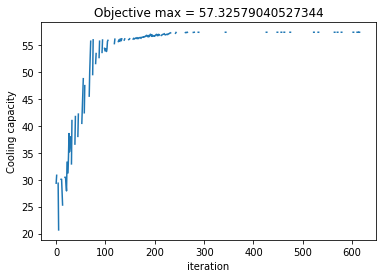

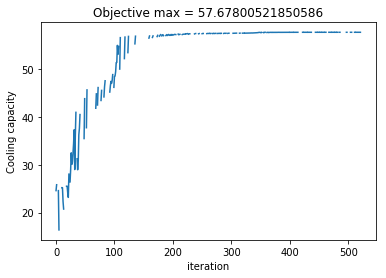

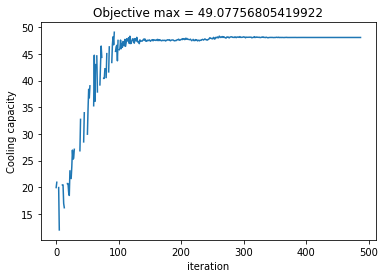

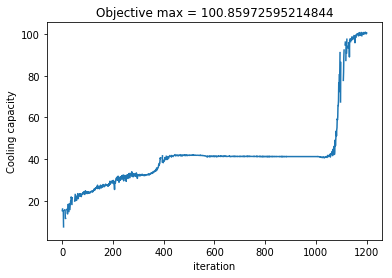

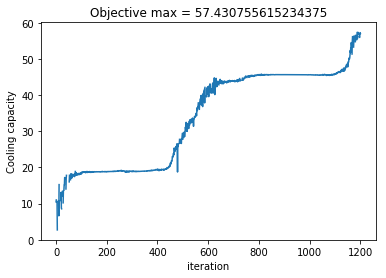

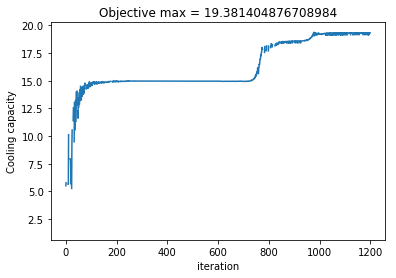

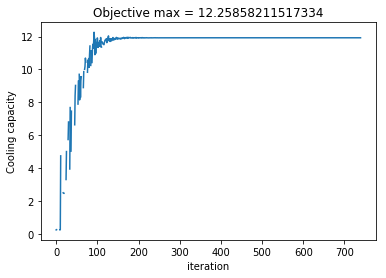

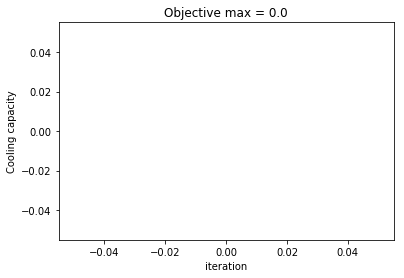

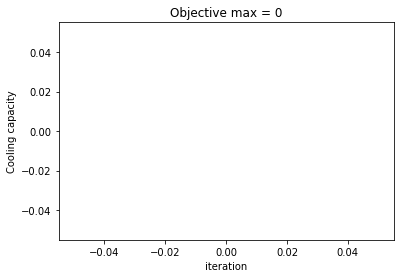

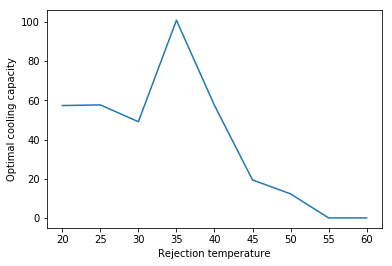

In [10]:
nbplayback('data3')

These data files
* Use hardConstraints = False
* method = Powell

Loaded the case from  ../data4/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data4/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data4/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data4/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data4/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data4/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data4/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data4/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data4/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


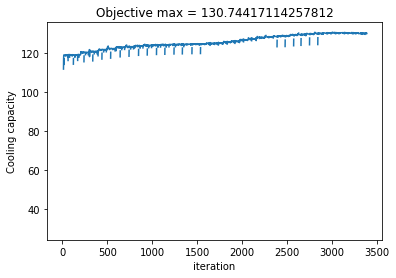

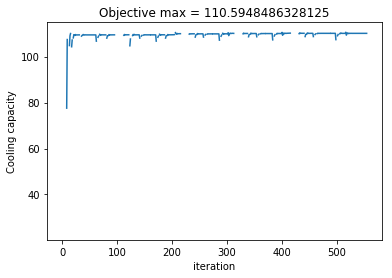

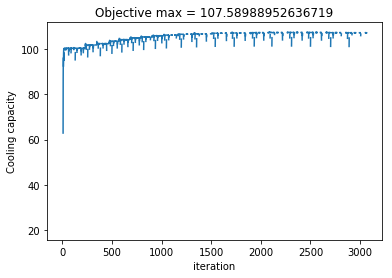

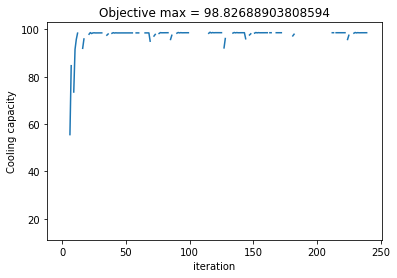

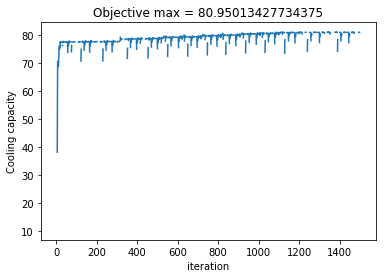

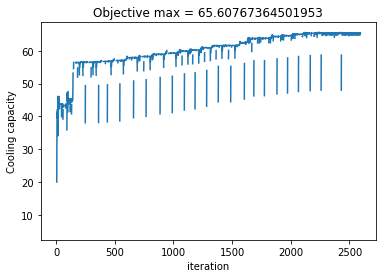

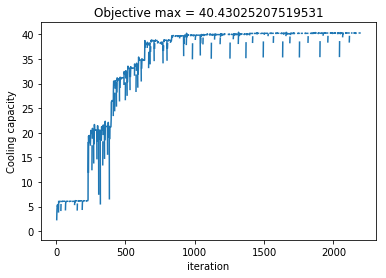

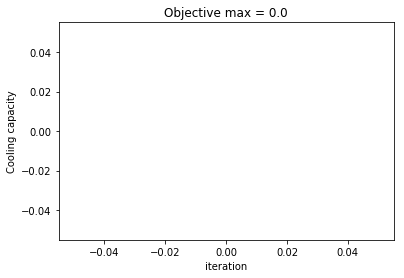

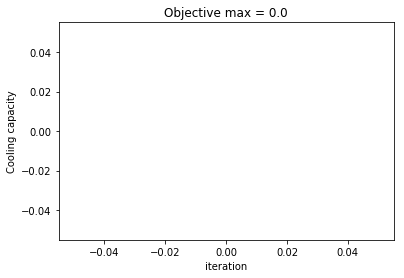

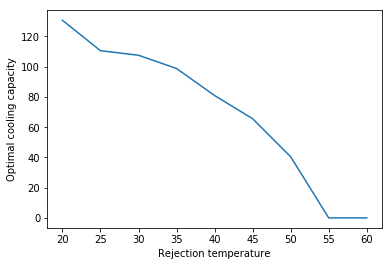

In [11]:
nbplayback('data4')

These data files
* Use hardConstraints = False
* method = CG

Loaded the case from  ../data5/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data5/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data5/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data5/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data5/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data5/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data5/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data5/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data5/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


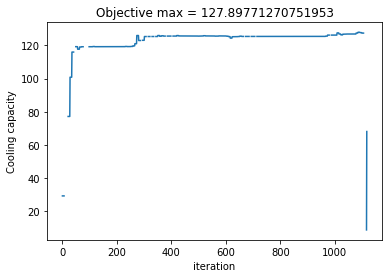

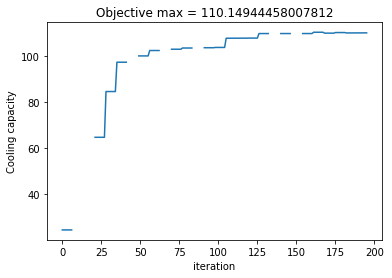

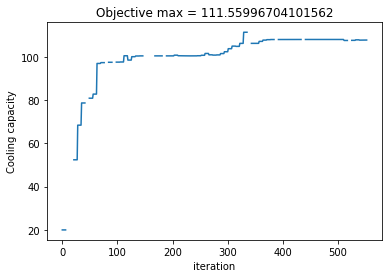

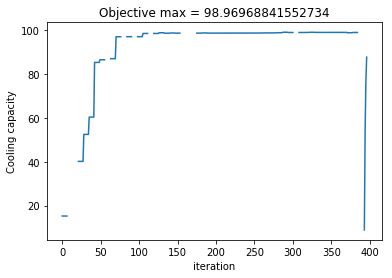

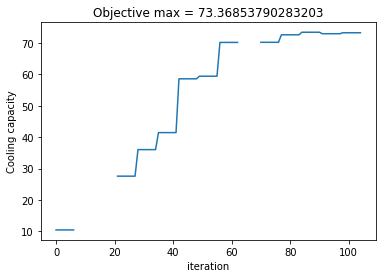

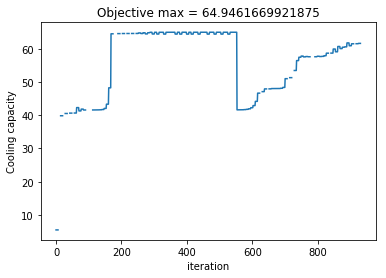

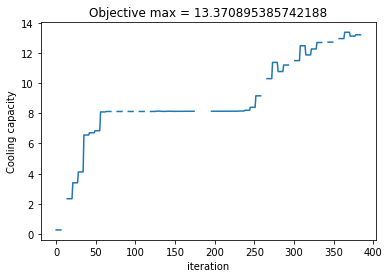

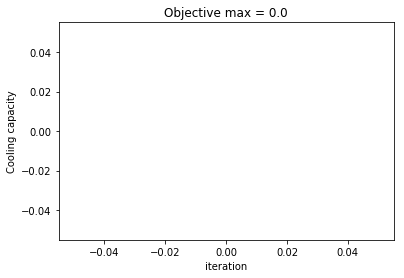

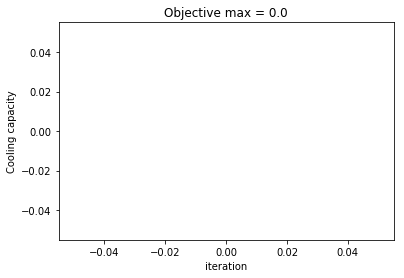

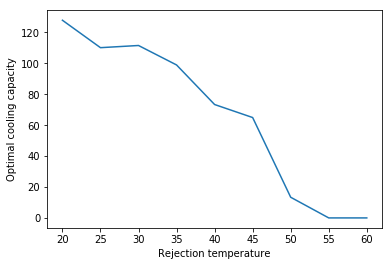

In [12]:
nbplayback('data5')

This trial contains no readme file.
Loaded the case from  ../data6/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data6/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data6/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data6/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data6/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data6/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data6/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data6/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data6/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


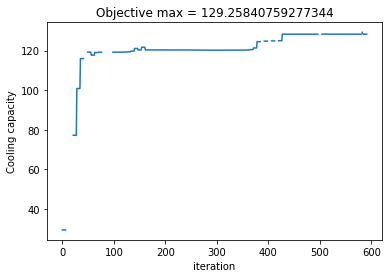

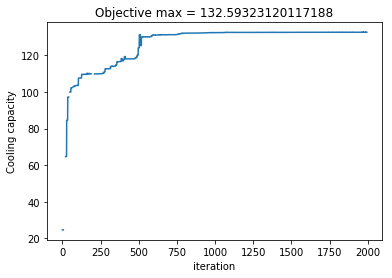

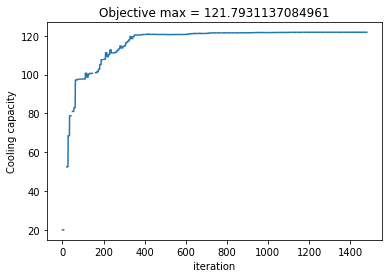

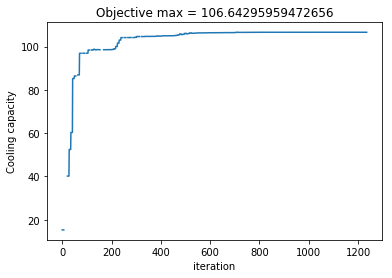

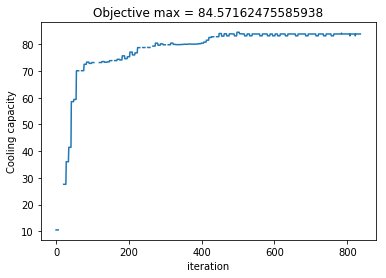

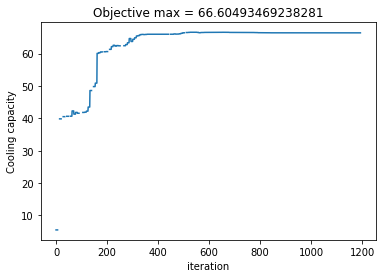

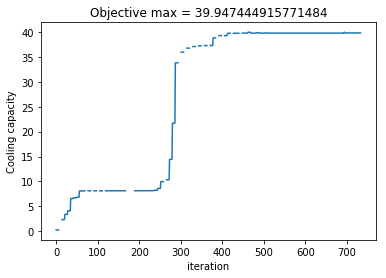

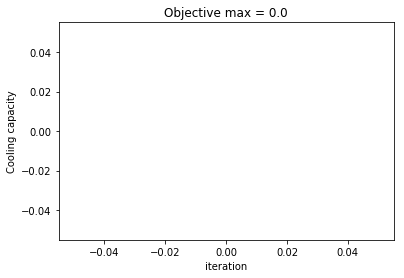

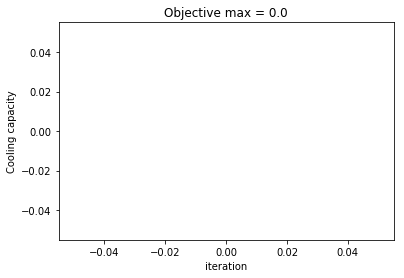

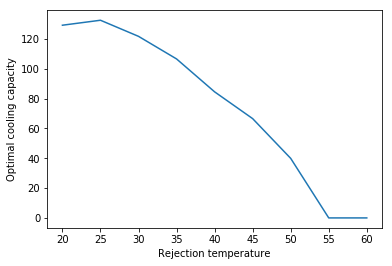

In [13]:
nbplayback('data6')

This trial contains no readme file.
Loaded the case from  ../data7/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data7/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data7/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data7/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data7/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data7/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data7/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data7/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data7/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


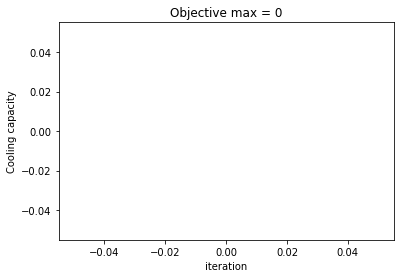

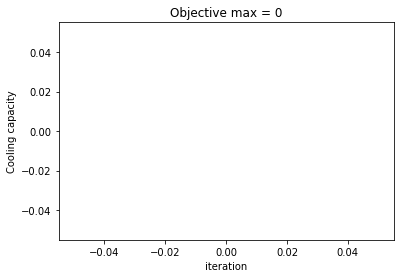

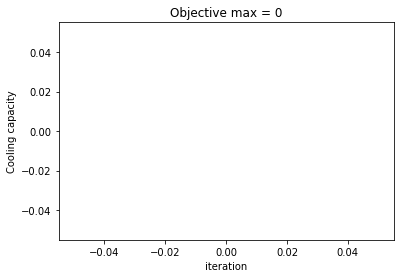

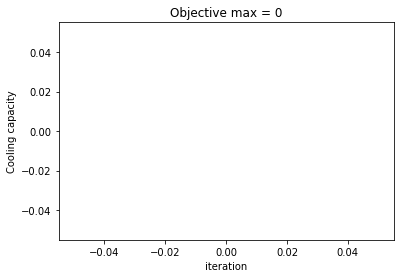

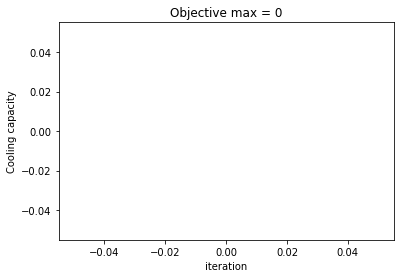

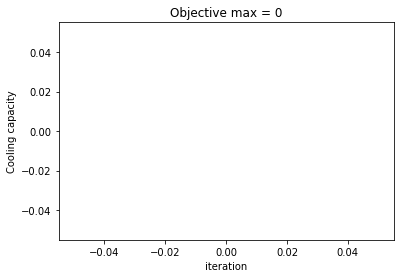

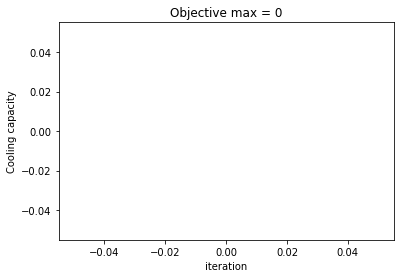

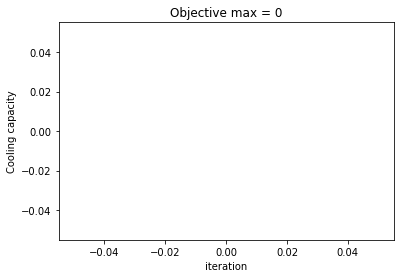

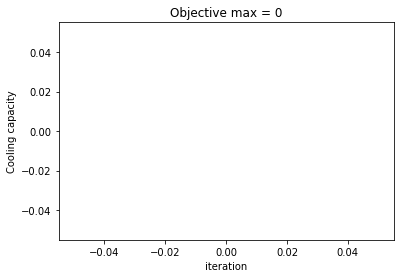

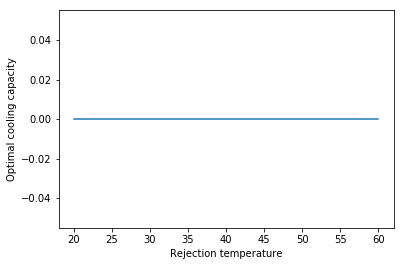

In [14]:
nbplayback('data7')

This trial contains no readme file.
Loaded the case from  ../data8/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data8/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data8/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data8/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data8/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data8/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data8/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data8/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data8/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


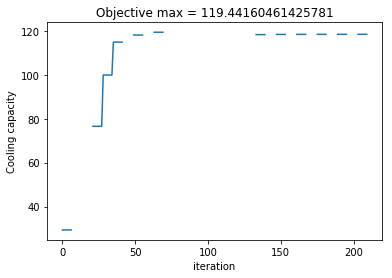

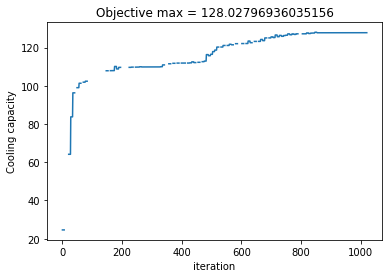

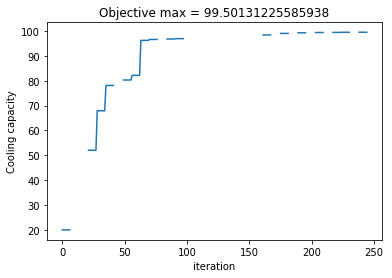

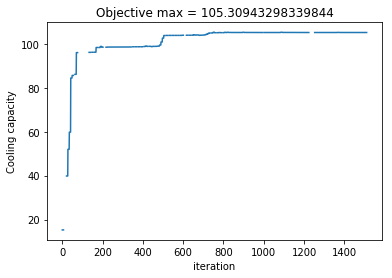

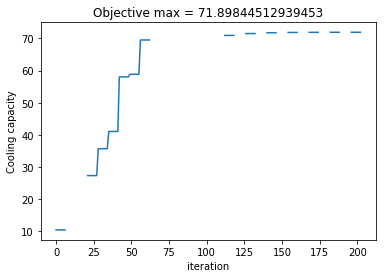

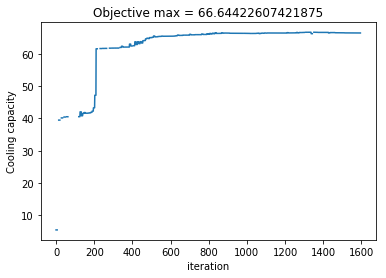

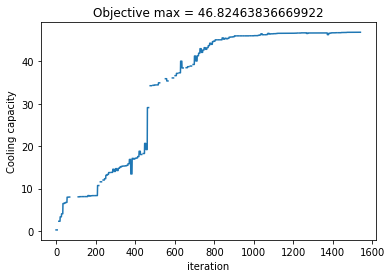

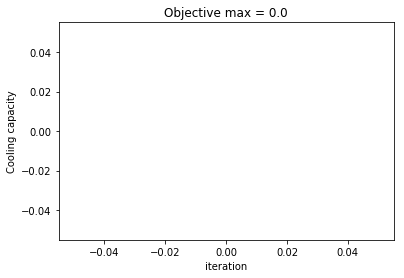

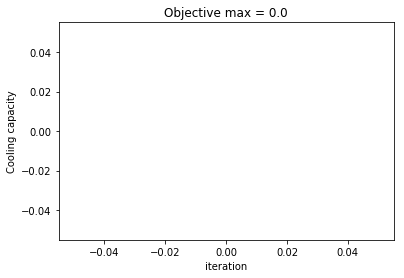

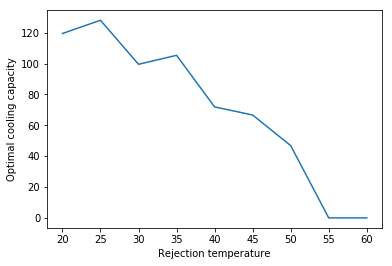

In [15]:
nbplayback('data8')

This trial contains no readme file.
Loaded the case from  ../data9/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data9/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data9/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data9/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data9/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Loaded the case from  ../data9/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data9/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data9/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data9/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


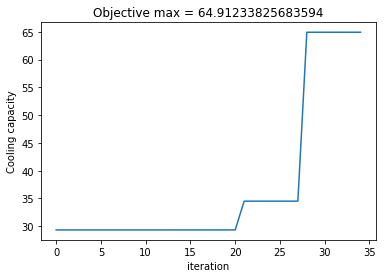

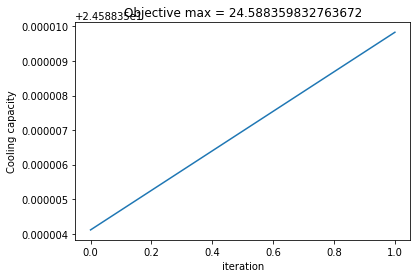

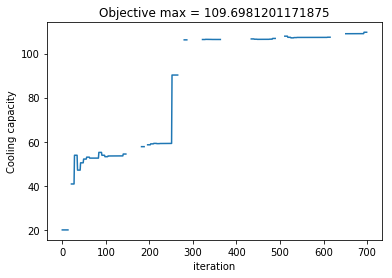

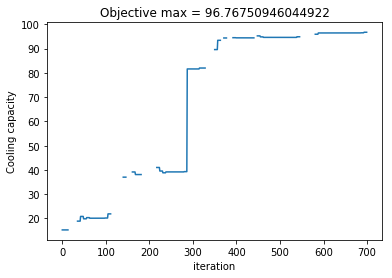

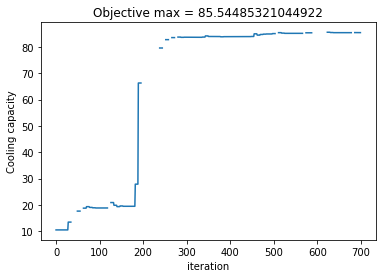

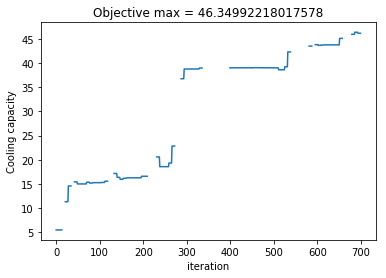

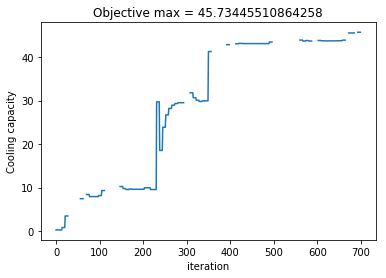

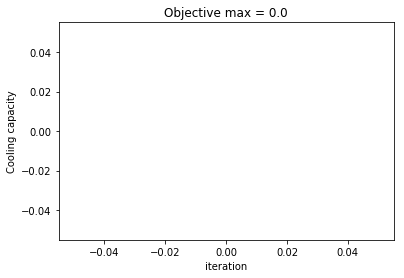

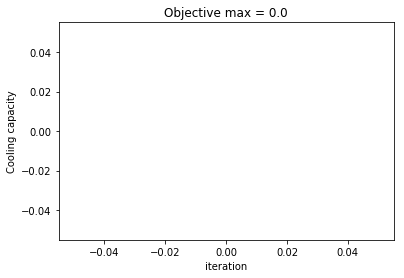

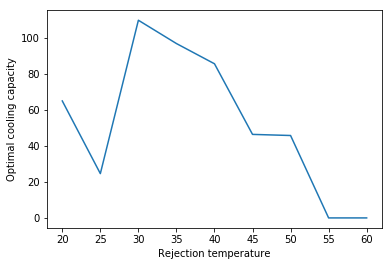

In [16]:
nbplayback('data9')

This trial contains no readme file.
Loaded the case from  ../data10/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Documents\GitHub\openACHP\src\aqua_case_studies2.py:91: RuntimeWarning: invalid value encountered in greater_equal
  mask = (po['cons'] >= 0).all(axis=1)
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data10/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data10/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data10/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data10/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data10/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data10/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data10/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data10/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


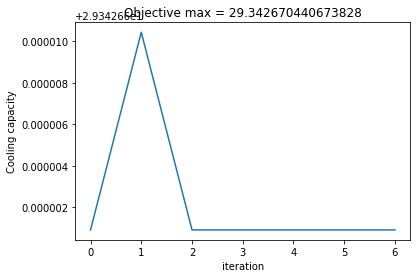

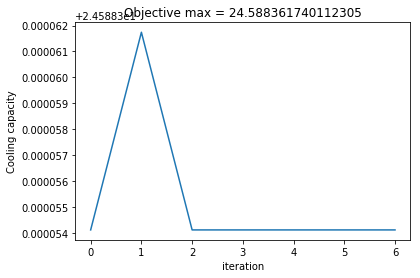

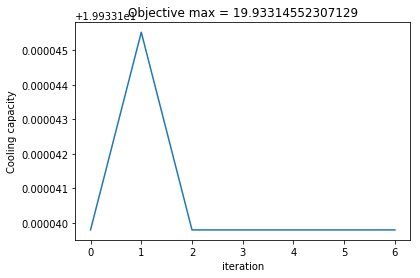

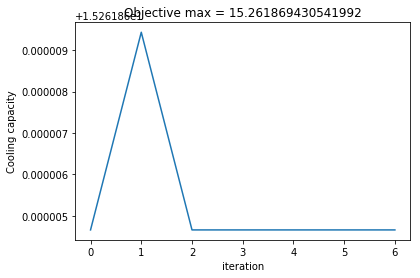

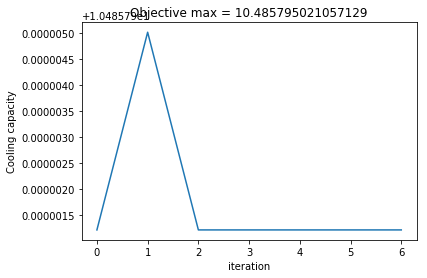

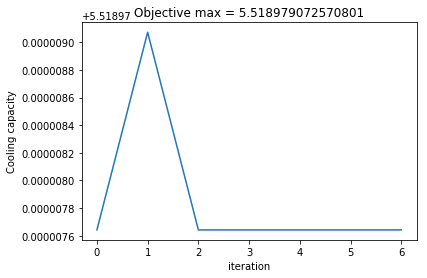

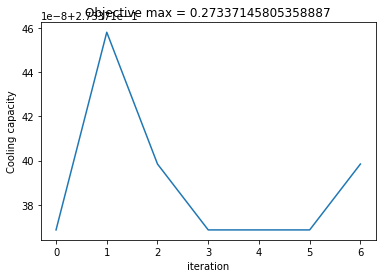

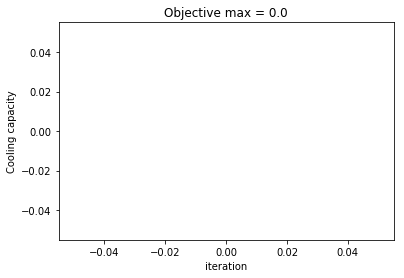

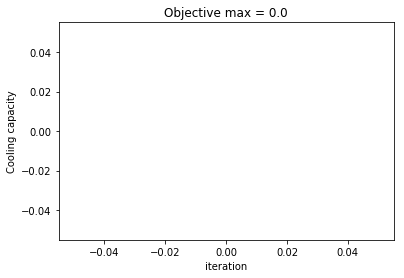

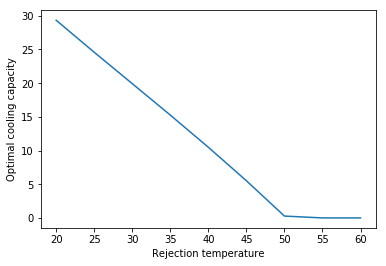

In [17]:
nbplayback('data10')

This trial contains no readme file.
Loaded the case from  ../data11/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data11/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data11/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data11/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data11/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data11/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data11/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data11/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data11/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


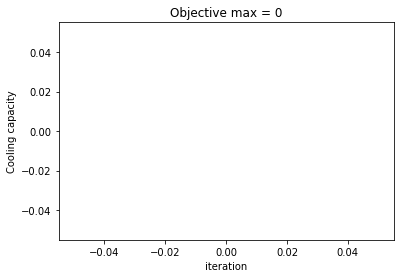

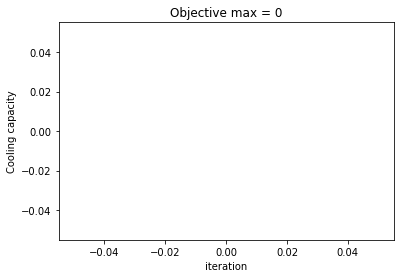

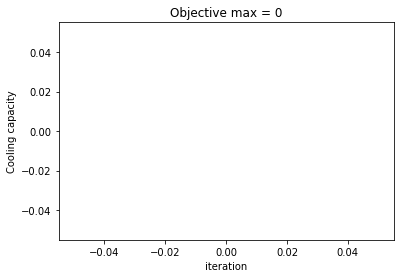

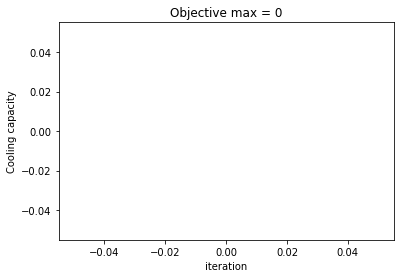

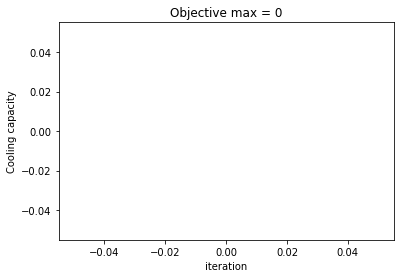

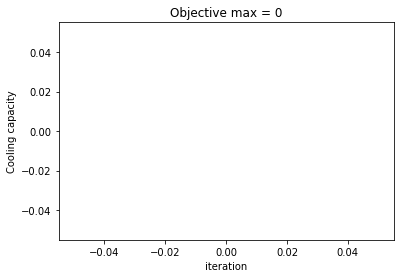

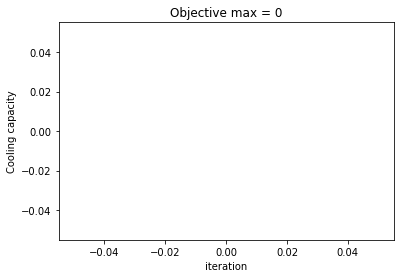

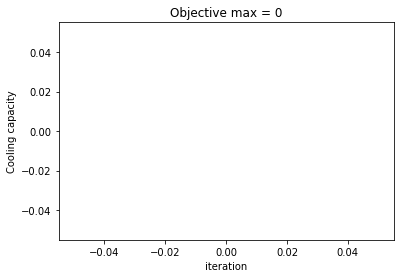

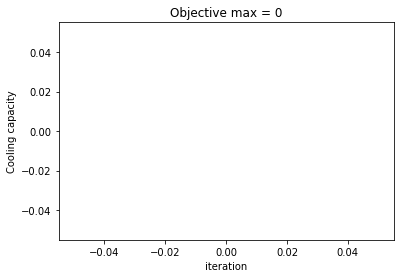

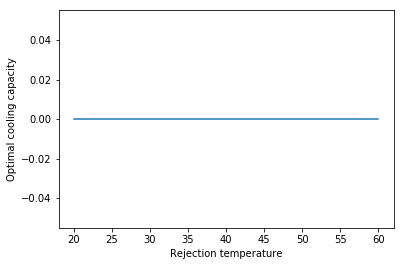

In [29]:
nbplayback('data11')

This trial contains no readme file.
Loaded the case from  ../data12/system_aqua1_100_90491be93aff6cd2b9d684382bb534f2.pkl


C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\user1\Miniconda3\envs\openachp\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


Loaded the case from  ../data12/system_aqua1_100_262d49e60c00735830979de1523f5d00.pkl
Loaded the case from  ../data12/system_aqua1_100_45ca83277be3e9a5971e1fa2d9ac5b00.pkl
Loaded the case from  ../data12/system_aqua1_100_149c09da3311ef9d24f5c64b18fd1b1d.pkl
Loaded the case from  ../data12/system_aqua1_100_ddc0526bcf3ef647915f89590fddf49a.pkl
Loaded the case from  ../data12/system_aqua1_100_5c73391993c5e1da1c590c58dd6d3459.pkl
Loaded the case from  ../data12/system_aqua1_100_5ce7666527ab3509ca6c6bfe5799f2d4.pkl
Loaded the case from  ../data12/system_aqua1_100_f430a1079eaddf114aab8afa74eabd87.pkl
Loaded the case from  ../data12/system_aqua1_100_59aa7fe7687bf60e9153231eff92b4a6.pkl


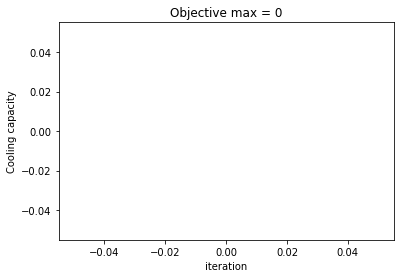

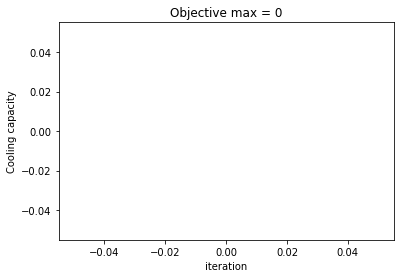

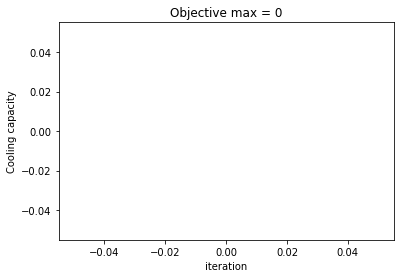

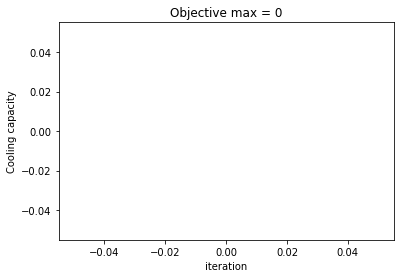

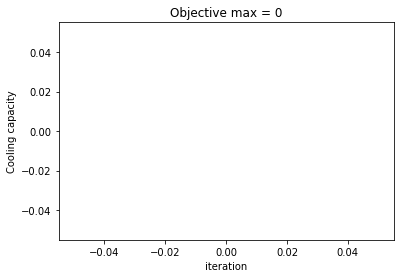

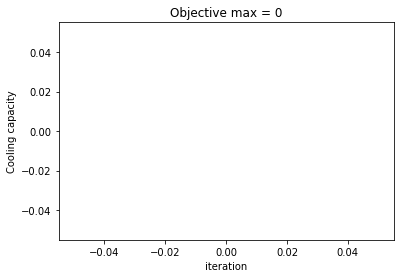

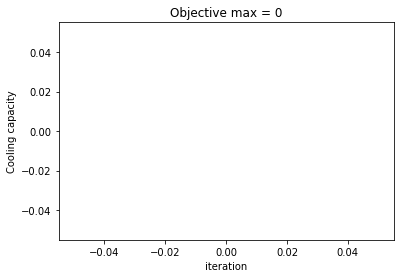

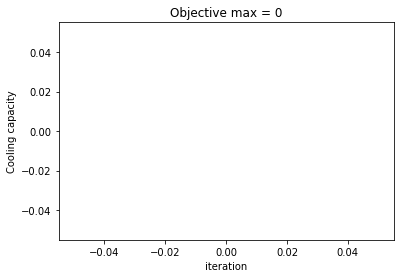

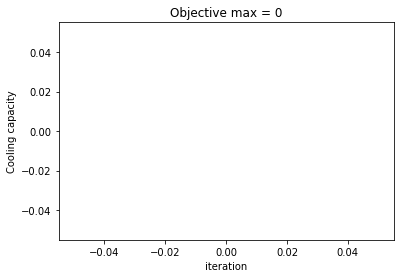

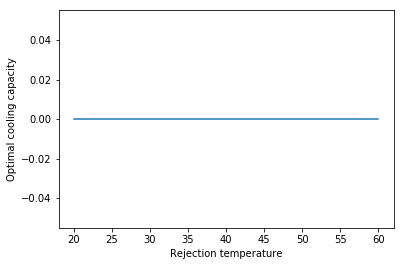

In [19]:
nbplayback('data12')

In [30]:
for key,val in aqua_case_studies2.trials.items():
    print(key,val.keys())

data dict_keys(['method', 'options', 'results'])
data2 dict_keys(['method', 'results'])
data3 dict_keys(['method', 'results'])
data4 dict_keys(['method', 'results'])
data5 dict_keys(['method', 'results'])
data6 dict_keys(['method', 'results'])
data7 dict_keys(['method', 'results'])
data8 dict_keys(['method', 'results'])
data9 dict_keys(['method', 'results'])
data10 dict_keys(['method', 'results'])
data11 dict_keys(['method', 'results'])
data12 dict_keys(['method', 'results'])


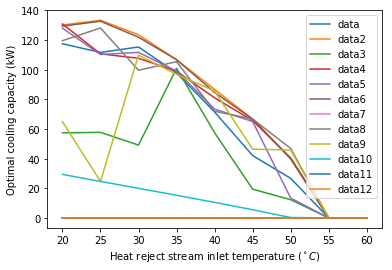

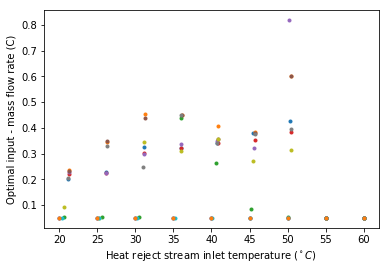

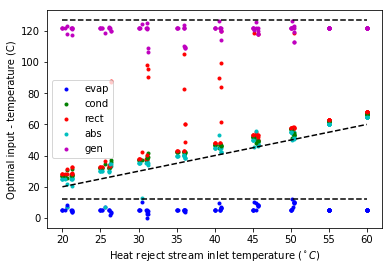

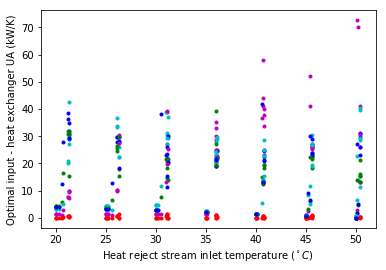

In [31]:
import matplotlib.pyplot as plt
import numpy
plt.figure(1)
plt.xlabel('Heat reject stream inlet temperature (${^\circ}C$)')
plt.ylabel('Optimal cooling capacity (kW)')
plt.figure(2)
plt.xlabel('Heat reject stream inlet temperature (${^\circ}C$)')
plt.ylabel('Optimal input - mass flow rate (C)')
plt.figure(3)
plt.xlabel('Heat reject stream inlet temperature (${^\circ}C$)')
plt.ylabel('Optimal input - temperature (C)')

plt.figure(4)
plt.xlabel('Heat reject stream inlet temperature (${^\circ}C$)')
plt.ylabel('Optimal input - heat exchanger UA (kW/K)')

labeling = True
labeliter = iter(['evap','cond','rect','abs','gen']+[None]*100)
labeliter2 = iter(['evap','cond','rect','abs','gen']+[None]*999)
for folder in aqua_case_studies2.trials:
    T, Q, list_xC, list_system_data = aqua_case_studies2.trials[folder]['results']
    a_xC = numpy.array(list_xC)
    m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet = a_xC.T
    
    # How to indicate correlation to objective for other variables?
    # Try this: offset temperatures.
    t_offset = numpy.array(Q) * 0.01
    
    plt.figure(1)
    plt.plot(T,Q, label=folder)
    
    plt.figure(2)
    plt.plot(T + t_offset,m_rich,'.')
    
    plt.figure(3)
    plt.plot(T + t_offset,T_evap - 273.15,'b.',label=next(labeliter))
    plt.plot(T + t_offset,T_cond - 273.15,'g.',label=next(labeliter))
    plt.plot(T + t_offset,T_rect - 273.15,'r.',label=next(labeliter))
    plt.plot(T + t_offset,T_abs_outlet - 273.15,'c.',label=next(labeliter))
    plt.plot(T + t_offset,T_gen_outlet - 273.15,'m.',label=next(labeliter))
    
    # We should try plotting the UA values, too.
    plt.figure(4)
    colors = dict(zip('evap cond rect abs gen'.split(),
                      'b g r c m'.split()))
    for (t, sys_data) in zip(T + t_offset, list_system_data):
        for name, deltaT, epsilon, UA, Qhx in sys_data:
            plt.plot(t, UA, colors[name] + '.')

plt.figure(3)
plt.plot(T,T,'k--')
plt.plot(T,numpy.ones_like(T)*(400-273.15),'k--')
plt.plot(T,numpy.ones_like(T)*(285-273.15),'k--')

plt.figure(1)
plt.legend(loc='best')
plt.figure(3)
plt.legend(loc='best')
plt.show()

### Discussion

To critique the results: first, for optimal cooling capacity vs heat rejection source temperature, I would expect to see a monotonically decreasing trend, smoothness, and agreement between several of the optimization methods. However, the curves are generally jumpy and several have a drop at the lowest temperature. Admittedly, some of the results for the optimal cooling capacity vs heat rejection source temperature are "not too bad", as in having roughly the expected trend allowing for, say, 20% disparity (cases `data`, `data3`, `data4`, `data5`, and `data6`). Secondly, regarding convergence, we can discuss adherence to constraints and speed. Blank intervals on the convergence plots are used to indicate that the optimizer gave the model a non-feasible input. We can see that this happens rather frequently. For speed, many of the optimizers run at around 1000 iterations, which seems not too bad; however, each iteration takes about a second for the model to solve. So we either need a faster model solver or faster convergence in order to make a user-friendly tool that approximates a real-time response. Notably, the COBYLA method in `data` converges very quickly for some, but not all, of the inputs. A possible approach is to build a fast, approximate model to get an initial guess at the optimum design, then finish optimizing with the full accuracy model.

(Toward the goal of having the faster, approximate model, I started creating some classes to use UA-LMTD style equations; see `class counterflowPoints` in `HRHX_integral_model.py` at commit [4f2661c](https://github.com/nfette/openACHP/commit/4f2661c7986c10031ed0cd0fb02f309161905a1e).)

I've added three plots showing the trends of "other variables" with respect to the heat reject temperature. When optimization is working, the point clouds should collapse. Since the reject temperatures are discrete, I have spread the clouds horizontally based on the corresponding output (cooling capacity) as if using a third axis. (Later, this could be a nice approach to visualizing sensitivity with respect to each variables.)

## GenOpt trials

Note that these trials are single point optimization trials, unlike the parameter sweep studies above. (In order to run parametric studies with GenOpt, I would need to write some batch files to duplicate the input files and vary the chosen parameter.)

### Setup for opt1

I ran these trials using the GPSHookeJeeves algorithm, set up in this way in `command.txt`. Temperatures are in Kelvin.

```java
/* GenOpt command file */

Vary{
  Parameter{ Name = m_rich;       Min = 0.01; Ini = 0.1; Max = 1; Step = 0.01; }
  Parameter{ Name = T_evap;       Min = 273.65; Ini = 274.15; Max = 280.15; Step = 0.5; }
  Parameter{ Name = T_cond;       Min = 305.15; Ini = 312.15; Max = 333.15; Step = 0.5; }
  Parameter{ Name = T_rect;       Min = 305.15; Ini = 313.15; Max = 333.15; Step = 0.5; }
  Parameter{ Name = T_abs_outlet; Min = 305.15; Ini = 310.15; Max = 333.15; Step = 0.5; }
  Parameter{ Name = T_gen_outlet; Min = 303.65; Ini = 393.15; Max = 473.15; Step = 0.5; }
}

OptimizationSettings{
  MaxIte = 2000;
  MaxEqualResults = 100;
  WriteStepNumber = true;
}

Algorithm{
 Main = GPSHookeJeeves;
 MeshSizeDivider = 2;
 InitialMeshSizeExponent = 0;
 MeshSizeExponentIncrement = 1;
 NumberOfStepReduction = 4;
}
```

The problem was specified in `xTemplate.txt`. This indicates that inlets for heat source, heat rejection, and cooling streams are 400 K, 305 K (32 C), and 285 K, with the indicated mass flow rates.

```java
{
"stepNumber":%stepNumber%,
"UAgoal":100.0,
"xB":[400.0,1.0, 305.0,3.0, 305.0,5.0, 285.0,4.0, 305.0,0.15],
"xC":[%m_rich%,
    %T_evap%,
    %T_cond%,
    %T_rect%,
    %T_abs_outlet%,
    %T_gen_outlet%]
}
```

### Setup for trial opt2

In this trial I increased the `step` parameter for all input variables:

```java
Vary{
  Parameter{ Name = m_rich;       Min = 0.01; Ini = 0.1; Max = 1; Step = 0.1; }
  Parameter{ Name = T_evap;       Min = 273.65; Ini = 274.15; Max = 280.15; Step = 5; }
  Parameter{ Name = T_cond;       Min = 305.15; Ini = 312.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_rect;       Min = 305.15; Ini = 313.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_abs_outlet; Min = 305.15; Ini = 310.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_gen_outlet; Min = 303.65; Ini = 393.15; Max = 473.15; Step = 5; }
}
```

The problem specification was otherwise identical to `opt1`.

### Setup for trial opt3

Here I kept the setup from `opt2` but increased the heat rejection temperatures from 305 K to 310 K.

```java
{
"stepNumber":%stepNumber%,
"UAgoal":100.0,
"xB":[400.0,1.0, 310.0,3.0, 310.0,5.0, 285.0,4.0, 310.0,0.15],
"xC":[%m_rich%,
    %T_evap%,
    %T_cond%,
    %T_rect%,
    %T_abs_outlet%,
    %T_gen_outlet%]
}
```

### Setup for trial opt4

In this trial I increased heat rejection temperature further, to 315 K, and also adjusted the lower bounds on some of the temperature variables, hoping for improved performance:

```java
Vary{
  Parameter{ Name = m_rich;       Min = 0.01; Ini = 0.1; Max = 1; Step = 0.1; }
  Parameter{ Name = T_evap;       Min = 273.65; Ini = 274.15; Max = 280.15; Step = 5; }
  Parameter{ Name = T_cond;       Min = 315.15; Ini = 322.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_rect;       Min = 315.15; Ini = 323.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_abs_outlet; Min = 315.15; Ini = 320.15; Max = 333.15; Step = 5; }
  Parameter{ Name = T_gen_outlet; Min = 303.65; Ini = 393.15; Max = 473.15; Step = 5; }
}
```

### Setup for trial opt5

Pending -- at the moment, `opt5` appears only to be a template for the next trial.

### Results with GenOpt

During trials, GenOpt stores data in several different locations.

- Input variable: logs/&lt;step number&gt;x.log
- Objective value: logs/&lt;step number&gt;f.log
- Simulation text outputs (other computed values): logs/&lt;step number&gt;simlog.log

Anyway, here are the results for trial `opt1`.

In [32]:
from numpy import genfromtxt, dtype
from tabulate import tabulate
from IPython.display import HTML
import matplotlib.pyplot as plt

def linkit(html):
    import base64
    return HTML("<a href='data:text/html;base64,{}'>Click me</a>".format(
        base64.b64encode(bytes(html,encoding='utf-8')).decode()))

# Borrowed from http://blog.dornea.nu/2014/08/28/using-jquery-datatables-with-ipython/
# Fix:
#   - use https to match target protocol
#   - use format() instead of string substitute
#   - updated links, see datatables.net
#   - then it stopped working, see https://github.com/jupyter/notebook/issues/499
import uuid
def DataTable(html):
    """ Prints a table as JQuery DataTables """
    # Generate random container name
    id_container = uuid.uuid1()
    output = """
        <div id="datatable-container-{idc}">
            <!-- Per blog
            <link rel="stylesheet" type="text/css" href="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/css/jquery.dataTables.css">
            <link rel="stylesheet" type="text/css" href="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/css/jquery.dataTables_themeroller.css">
            <script type="text/javascript" charset="utf8" src="http://ajax.aspnetcdn.com/ajax/jquery.dataTables/1.9.0/jquery.dataTables.min.js"></script>
            -->
            <!-- Updated, per datatables CDN, via https
            <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.16/css/jquery.dataTables.css">
            <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.10.16/js/jquery.dataTables.js"></script>
            -->
            <!-- Revert to last working, per datatables CDN, via https -->
            <link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.9.3/css/jquery.dataTables.css">
            <script type="text/javascript" charset="utf8" src="https://cdn.datatables.net/1.9.3/js/jquery.dataTables.js"></script>
            

            <script type="text/javascript">
                //$.getScript('https://cdn.datatables.net/1.10.16/js/jquery.dataTables.js');
                $('#datatable-container-{idc} table').dataTable();
                $(document).ready(function() {{
                        $('#datatable-container-{idc} table').dataTable();
                }});
            </script>
            <!-- Insert table below -->
            {html}
        </div>
    """.format(idc=id_container, html=html)
    return HTML(output)


def show_output_listing(filename, type='all'):
    if type == 'all':
        firstn = ("sim","main_i","sub_i","step")
    else:
        firstn = ("sim","main_i","step")

    nlines = 0
    for line in open(filename):
        nlines += 1

    names_data = genfromtxt(filename, skip_header=19, skip_footer=nlines-19, names=True, delimiter='\t',)
    the_dtype = dtype(names_data.dtype.descr + [('Message','U256')])
    data = genfromtxt(filename, dtype=the_dtype, skip_header=20, delimiter='\t', )

    style = "<style>th {transform: rotate(-90deg); transform-origin: left top 0;} thead.th { height: 300 px; display:block;}</style>Nothing<br/>"
    style = ""
    table_html = tabulate(data,firstn+the_dtype.names[len(firstn):],tablefmt='html')
    #display(HTML(style + table_html))
    #display(linkit(table_html))
    display(DataTable(table_html))

    plt.plot(data['Q_evap'])
    plt.ylabel('Q_evap (kW)')
    plt.xlabel('Simulation progress')
    plt.show()
    
    return data

sim,main_i,sub_i,step,objective,Q_evap,UA_gen,UA_rect,UA_abs,UA_cond,UA_evap,deltaT_gen,deltaT_rect,deltaT_abs,deltaT_cond,deltaT_evap,con1,con2,con3,con4,con5,mu,sum_g_barrier,m_rich,T_evap,T_cond,T_rect,T_abs_outlet,T_gen_outlet,Message
1,1,1,1,-131.146,29.7736,2.8654,0.217054,5.12017,4.33837,2.63959,6.85017,7.75748,2.79014,5.96173,10.4314,0.1,38,1,80,83,3,33.7909,0.1,274.15,312.15,313.15,310.15,393.15,Initial point.
2,2,1,1,-133.209,32.7509,3.22166,0.241247,5.69541,4.82557,2.92794,6.85017,7.75749,2.79014,5.83484,10.2533,0.11,38,1,80,83,3,33.4859,0.11,274.15,312.15,313.15,310.15,393.15,Cost reduced at m_rich+dm_rich.
3,2,2,1,-131.624,33.4249,3.22938,0.244323,5.9648,4.93934,3.13366,6.8501,7.76149,2.59936,5.80557,9.71658,0.11,37.5,1,80,83,3,32.7331,0.11,274.65,312.15,313.15,310.15,393.15,Cost not reduced at T_evap+dT_evap.
4,2,3,1,-134.822,32.0783,3.21326,0.238069,5.44091,4.71274,2.74038,6.85018,7.75363,2.98918,5.864,10.791,0.11,38.5,1,80,83,3,34.248,0.11,273.65,312.15,313.15,310.15,393.15,Cost reduced at T_evap-dT_evap.
5,2,4,1,-133.163,31.6396,3.20855,0.260432,5.235,4.27465,2.69972,6.85008,6.59027,3.19861,6.38481,10.8173,0.11,39,0.5,80,83,3,33.841,0.11,273.65,312.65,313.15,310.15,393.15,Cost not reduced at T_cond+dT_cond.
6,2,5,1,-134.015,32.514,3.21759,0.232409,5.66081,5.21044,2.78086,6.85014,8.0916,2.78266,5.34439,10.7649,0.11,38,1.5,80,83,3,33.8337,0.11,273.65,311.65,313.15,310.15,393.15,Cost not reduced at T_cond-dT_cond.
7,2,6,1,-137.363,32.0783,3.21326,0.22439,5.44091,4.72428,2.74038,6.85018,8.60067,2.98918,5.864,10.791,0.11,38.5,1.5,79.5,83,3,35.095,0.11,273.65,312.15,313.65,310.15,393.15,Cost reduced at T_rect+dT_rect.
8,2,7,1,-138.76,31.4907,3.2019,0.221895,4.92763,4.62754,2.68594,6.85009,8.59995,3.59107,5.88905,10.8262,0.11,38.5,1.5,79.5,82.5,3,35.7563,0.11,273.65,312.15,313.65,310.65,393.15,Cost reduced at T_abs_outlet+dT_abs_outlet.
9,2,8,1,-137.185,31.7934,3.32498,0.22426,5.01738,4.67733,2.71396,6.35019,8.59995,3.49607,5.87615,10.8081,0.11,38.5,1.5,80,83,3,35.1304,0.11,273.65,312.15,313.65,310.65,393.65,Cost not reduced at T_gen_outlet+dT_gen_outlet.
10,2,9,1,-140.337,31.1854,3.0876,0.219514,4.83929,4.57745,2.65772,7.3501,8.59995,3.68735,5.90206,10.8444,0.11,38.5,1.5,79,82,3,36.3839,0.11,273.65,312.15,313.65,310.65,392.65,Cost reduced at T_gen_outlet-dT_gen_outlet.


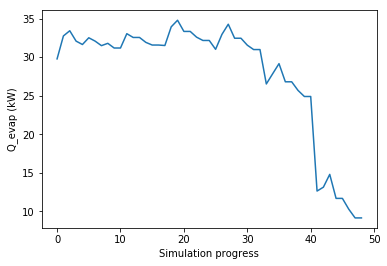

In [33]:
data1 = show_output_listing('../opt1/OutputListingAll.txt');

sim,main_i,sub_i,step,objective,Q_evap,barrier_and_penalty,barrier,penalty,mu1,mu2,m_rich,T_evap,T_cond,T_rect,T_abs_outlet,T_gen_outlet,Message
1,1,1,1,-265.565,29.7736,-235.791,-235.791,0,1,1,0.1,274.15,312.15,313.15,310.15,393.15,Initial point.
2,2,1,1,-292.277,59.5472,-232.73,-232.73,0,1,1,0.2,274.15,312.15,313.15,310.15,393.15,Cost reduced at m_rich+dm_rich.
3,2,2,1,-292.344,72.0764,-220.268,-220.268,0,1,1,0.2,279.15,312.15,313.15,310.15,393.15,Cost reduced at T_evap+dT_evap.
4,2,3,1,1,-1,0,0,0,1,1,0.2,279.15,317.15,313.15,310.15,393.15,Cost not reduced at T_cond+dT_cond.
5,2,4,1,1,-1,0,0,0,1,1,0.2,279.15,307.15,313.15,310.15,393.15,Cost not reduced at T_cond-dT_cond.
6,2,5,1,-296.979,72.0764,-224.903,-224.903,0,1,1,0.2,279.15,312.15,318.15,310.15,393.15,Cost reduced at T_rect+dT_rect.
7,2,6,1,-287.316,60.9919,-226.324,-226.324,0,1,1,0.2,279.15,312.15,318.15,315.15,393.15,Cost not reduced at T_abs_outlet+dT_abs_outlet.
8,2,7,1,1,-1,0,0,0,1,1,0.2,279.15,312.15,318.15,305.15,393.15,Cost not reduced at T_abs_outlet-dT_abs_outlet.
9,2,8,1,-305.815,76.9086,-228.906,-228.906,0,1,1,0.2,279.15,312.15,318.15,310.15,398.15,Cost reduced at T_gen_outlet+dT_gen_outlet.
9,2,9,1,-305.815,76.9086,-228.906,-228.906,0,1,1,0.2,279.15,312.15,318.15,310.15,398.15,Global search reduced cost.


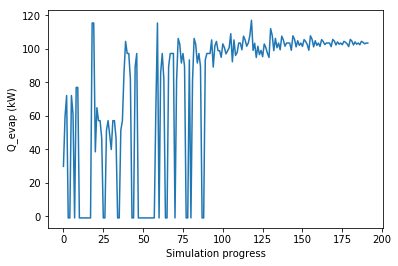

In [34]:
show_output_listing('../opt2/OutputListingAll.txt');

sim,main_i,sub_i,step,objective,Q_evap,barrier_and_penalty,barrier,penalty,mu1,mu2,m_rich,T_evap,T_cond,T_rect,T_abs_outlet,T_gen_outlet,Message
1,1,1,1,1,-1,0,0,0,1,1,0.1,274.15,312.15,313.15,310.15,393.15,Initial point.
2,2,1,1,1,-1,0,0,0,1,1,0.2,274.15,312.15,313.15,310.15,393.15,Cost not reduced at m_rich+dm_rich.
3,2,2,1,1,-1,0,0,0,1,1,0.1,279.15,312.15,313.15,310.15,393.15,Cost not reduced at T_evap+dT_evap.
4,2,3,1,1,-1,0,0,0,1,1,0.1,274.15,317.15,313.15,310.15,393.15,Cost not reduced at T_cond+dT_cond.
5,2,4,1,1,-1,0,0,0,1,1,0.1,274.15,307.15,313.15,310.15,393.15,Cost not reduced at T_cond-dT_cond.
6,2,5,1,1,-1,0,0,0,1,1,0.1,274.15,312.15,318.15,310.15,393.15,Cost not reduced at T_rect+dT_rect.
7,2,6,1,1,-1,0,0,0,1,1,0.1,274.15,312.15,308.15,310.15,393.15,Cost not reduced at T_rect-dT_rect.
8,2,7,1,-246.982,24.5524,-222.429,-222.429,0,1,1,0.1,274.15,312.15,313.15,315.15,393.15,Cost reduced at T_abs_outlet+dT_abs_outlet.
9,2,8,1,-253.411,27.3245,-226.086,-226.086,0,1,1,0.1,274.15,312.15,313.15,315.15,398.15,Cost reduced at T_gen_outlet+dT_gen_outlet.
9,2,9,1,-253.411,27.3245,-226.086,-226.086,0,1,1,0.1,274.15,312.15,313.15,315.15,398.15,Global search reduced cost.


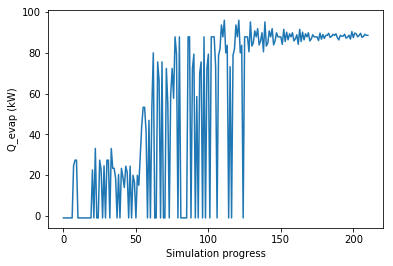

In [35]:
show_output_listing('../opt3/OutputListingAll.txt');

sim,main_i,sub_i,step,objective,Q_evap,barrier_and_penalty,barrier,penalty,mu1,mu2,m_rich,T_evap,T_cond,T_rect,T_abs_outlet,T_gen_outlet,Message
1,1,1,1,-240.804,10.434,-230.369,-230.369,0,1,1,0.1,274.15,322.15,323.15,320.15,393.15,Initial point.
2,2,1,1,-250.193,20.8681,-229.325,-229.325,0,1,1,0.2,274.15,322.15,323.15,320.15,393.15,Cost reduced at m_rich+dm_rich.
3,2,2,1,-251.246,33.1118,-218.134,-218.134,0,1,1,0.2,279.15,322.15,323.15,320.15,393.15,Cost reduced at T_evap+dT_evap.
4,2,3,1,1,-1,0,0,0,1,1,0.2,279.15,327.15,323.15,320.15,393.15,Cost not reduced at T_cond+dT_cond.
5,2,4,1,-253.73,42.2228,-211.508,-211.508,0,1,1,0.2,279.15,317.15,323.15,320.15,393.15,Cost reduced at T_cond-dT_cond.
6,2,5,1,-257.941,42.2228,-215.718,-215.718,0,1,1,0.2,279.15,317.15,328.15,320.15,393.15,Cost reduced at T_rect+dT_rect.
7,2,6,1,-248.884,32.1577,-216.726,-216.726,0,1,1,0.2,279.15,317.15,328.15,325.15,393.15,Cost not reduced at T_abs_outlet+dT_abs_outlet.
8,2,7,1,1,-1,0,0,0,1,1,0.2,279.15,317.15,328.15,315.15,393.15,Cost not reduced at T_abs_outlet-dT_abs_outlet.
9,2,8,1,-267.203,48.1991,-219.004,-219.004,0,1,1,0.2,279.15,317.15,328.15,320.15,398.15,Cost reduced at T_gen_outlet+dT_gen_outlet.
9,2,9,1,-267.203,48.1991,-219.004,-219.004,0,1,1,0.2,279.15,317.15,328.15,320.15,398.15,Global search reduced cost.


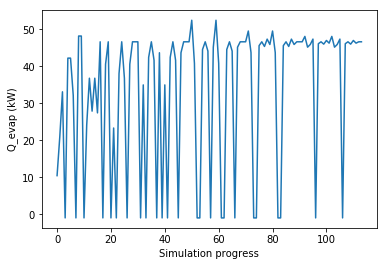

In [36]:
show_output_listing('../opt4/OutputListingAll.txt');

### Discussion of GenOpt trials

First let's compare optimized cooling capacity to results from the scipy.optimize trials. At heat reject temperatures of 32 C, 37 C, and 42 C, I would anticipate respective optima of about 115 kW (for `opt1` and `opt2`), 100 kW (for `opt3`), and 80 kW (`opt4`). For the first case, `opt1` seems to have headed off in the wrong direction, but `opt2` worked fairly well. Both `opt2` and `opt3` delivered optima near to what's expected. However, `opt3` delivered cooling capacity lower than desired.

One thing I notice is that barrier and penalty functions sometimes change signs. Probably they should be fixed (see note added above proposed constraint mode `genopt2`.)